# Оглавление

[1. Описание проекта](#glava_1)  
[2. Подготовка данных](#glava_2)  
[3. Предобработка данных](#glava_3)  
[4. Анализ данных](#glava_4)  
[5. Обучение моделей](#glava_5)  
[6. Анализ модели](#glava_6)  
[Вывод](#conclusion)  
 

<a id="glava_1"></a>

## Описание проекта

Металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Необходимо построить модель, которая предскажет температуру стали.

### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

<a id="glava_2"></a>

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import math

import warnings
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import make_scorer
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [3]:
data_arc.info() #данные об электродах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                     14876 non-null int64
Начало нагрева дугой    14876 non-null object
Конец нагрева дугой     14876 non-null object
Активная мощность       14876 non-null float64
Реактивная мощность     14876 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [4]:
data_arc['key'].nunique()

3214

In [5]:
data_arc.head()

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [6]:
data_arc.describe()

,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


In [7]:
data_arc.columns = ['key', 'start_arc_heating', 'end_arc_heating', 'active_power', 'reactive_power']

Данные об электродах включают в себя инофрмацию о партии продукции, величине затраченной на нагрев активной и реактивной мощности.  

Присутствуют аномалии в значении реактивной мощности.

In [8]:
data_bulk.info() #данные о подаче сыпучих материалов (объём)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null float64
Bulk 2     22 non-null float64
Bulk 3     1298 non-null float64
Bulk 4     1014 non-null float64
Bulk 5     77 non-null float64
Bulk 6     576 non-null float64
Bulk 7     25 non-null float64
Bulk 8     1 non-null float64
Bulk 9     19 non-null float64
Bulk 10    176 non-null float64
Bulk 11    177 non-null float64
Bulk 12    2450 non-null float64
Bulk 13    18 non-null float64
Bulk 14    2806 non-null float64
Bulk 15    2248 non-null float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [9]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


In [10]:
data_bulk_time.info() #данные о подаче сыпучих материалов (время)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
key        3129 non-null int64
Bulk 1     252 non-null object
Bulk 2     22 non-null object
Bulk 3     1298 non-null object
Bulk 4     1014 non-null object
Bulk 5     77 non-null object
Bulk 6     576 non-null object
Bulk 7     25 non-null object
Bulk 8     1 non-null object
Bulk 9     19 non-null object
Bulk 10    176 non-null object
Bulk 11    177 non-null object
Bulk 12    2450 non-null object
Bulk 13    18 non-null object
Bulk 14    2806 non-null object
Bulk 15    2248 non-null object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [11]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


Процесс подачи сыпучих материалов описан с помощью двух таблиц. Первая таблица указывает на партию, вид сырья и объема подачи. Вторая таблица указывает в какое время происходила подача.

In [12]:
data_gas.info()  #данные о продувке сплава газом

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
key      3239 non-null int64
Газ 1    3239 non-null float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [13]:
data_gas.tail()

,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


In [14]:
data_gas['key'].nunique()

3239

In [15]:
data_gas.columns = ['key', 'volume_gas']

Данные о продувке сплава газом, представлены суммарно для каждой партии продукции.

In [16]:
data_temp.info() #результаты измерения температуры

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
key             15907 non-null int64
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [17]:
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [18]:
data_temp.isna().sum() / data_temp.count()

key             0.000000
Время замера    0.000000
Температура     0.223051
dtype: float64

В целевой переменной  ~ 22% пропусков.

In [19]:
data_temp.describe()

,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


In [20]:
data_temp['key'].nunique()

3216

In [21]:
data_temp.columns = ['key', 'start_meas_temp', 'temp']

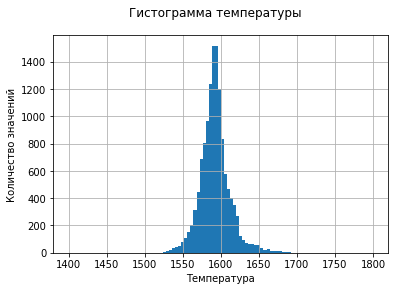

In [22]:
data_temp['temp'].hist(bins=100, range=(1400, 1800));
plt.suptitle('Гистограмма температуры')
plt.xlabel('Температура')
plt.ylabel('Количество значений')
plt.show()

Данные о последнем измерении температуры являются **целевой переменной**.   

Обучение модели возможно провести только для 3216 партий продукции. Это максимальное количество уникальных значений **key** в таблице **data_temp**.

Измерение температуры проводились на разных этапах производства каждой партии.  

Изменения зафиксированной температуры находятся в диапазоне от 1191 до 1705 градусов.  

Основная часть измерений температуры находится в пределах 100 градусов. Это указывает на то, что опускание электродов в ковш служит для поддержания температуры и подогрев, остывающего сырья.


In [23]:
data_wire.info() #данные о проволочных материалах (объём)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null float64
Wire 2    1079 non-null float64
Wire 3    63 non-null float64
Wire 4    14 non-null float64
Wire 5    1 non-null float64
Wire 6    73 non-null float64
Wire 7    11 non-null float64
Wire 8    19 non-null float64
Wire 9    29 non-null float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [24]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data_wire_time.info() #данные о проволочных материалах (время)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
key       3081 non-null int64
Wire 1    3055 non-null object
Wire 2    1079 non-null object
Wire 3    63 non-null object
Wire 4    14 non-null object
Wire 5    1 non-null object
Wire 6    73 non-null object
Wire 7    11 non-null object
Wire 8    19 non-null object
Wire 9    29 non-null object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [26]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Данные о проволочных материалах, как и данные о сыпучих материалах, включают объем и время загрузки.  


### Вывод

Производственный процесс представляет из себя цикл этапов, включающих опускание электродов в ковш(нагрев), добавление сыпучих материалов и проволки, продувка газов, замеры температуры.  

Данные о последнем измерении температуры являются **целевой переменной**.     

Изменения зафиксированной температуры находятся в диапазоне от 1191 до 1705 градусов и равен 514.  

<a id="glava_3"></a>
## Предобработка данных

In [27]:
data_arc.head()

,key,start_arc_heating,end_arc_heating,active_power,reactive_power
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


In [28]:
data_arc[['start_arc_heating', 'end_arc_heating']] = data_arc[['start_arc_heating', 'end_arc_heating']].apply(pd.to_datetime)

In [29]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
key                  14876 non-null int64
start_arc_heating    14876 non-null datetime64[ns]
end_arc_heating      14876 non-null datetime64[ns]
active_power         14876 non-null float64
reactive_power       14876 non-null float64
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


In [30]:
data_arc['key'].nunique()

3214

Вычислим время опускания электродов в ковш (нагрев) в секундах на каждом этапе для каждой партии.

In [31]:
data_arc['diff_seconds'] = (data_arc['end_arc_heating'] - data_arc['start_arc_heating'])/np.timedelta64(1,'s')

Вычислим и добавим в таблицу значение полной мощности **full_power**:

$$
S = \sqrt {P^2 + Q^2},
$$
где $ P $- активная  мощность; $ Q $ - реактивная  мощность.

In [32]:
data_arc['full_power'] = (data_arc['active_power'] ** 2 + data_arc['reactive_power'] ** 2).apply(math.sqrt)

Произведем группировку значений по партии продукции. Значения времени нагрева, активной, реактивной и полной мощности просуммируем и выведем столбец с указанием количества этапов в партии.

In [33]:
data_arc_batch = data_arc.groupby(['key']).agg({'active_power':['count','sum'], 'reactive_power':['sum'],
                                                'diff_seconds':['sum'], 'full_power':['sum']}).reset_index()

In [34]:
data_arc_batch.columns = ['key', 'count_arc', 'active_power_sum', 'reactive_power_sum', 'sum_time_arc', 'full_power_sum']

In [35]:
data_arc_batch.describe()

,key,count_arc,active_power_sum,reactive_power_sum,sum_time_arc,full_power_sum
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,1623.061294,4.628500,3.103138,2.094821,794.579029,4.104597
std,934.739859,1.608647,1.397390,12.689508,332.448622,12.700919
min,1.000000,1.000000,0.186226,-714.591636,57.000000,0.257637
25%,817.250000,4.000000,2.126339,1.599018,571.000000,2.677106
50%,1623.500000,4.000000,2.990537,2.229869,770.000000,3.753992
75%,2431.750000,6.000000,3.901147,2.899141,983.000000,4.858781
max,3241.000000,16.000000,17.496497,12.587990,4189.000000,717.137585


In [36]:
#данные о подаче сыпучих материалов (объём)
data_bulk.columns

Index(['key', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'],
      dtype='object')

In [37]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


Произведем преобразование таблицы **data_bulk** функцией *melt*

In [38]:
data_bulk_tidy = pd.melt(data_bulk, id_vars=['key'], value_vars=['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'], value_name='volume')

In [39]:
data_bulk_tidy = data_bulk_tidy.dropna().copy()

In [40]:
data_bulk_tidy.sort_values(by='key', ascending=True).head(10)

,key,variable,volume
43806,1,Bulk 15,154.0
34419,1,Bulk 12,206.0
40677,1,Bulk 14,150.0
9387,1,Bulk 4,43.0
43807,2,Bulk 15,154.0
9388,2,Bulk 4,73.0
34420,2,Bulk 12,206.0
40678,2,Bulk 14,149.0
43808,3,Bulk 15,153.0
34421,3,Bulk 12,205.0


In [41]:
data_bulk_tidy['key'].nunique()

3129

Произведем аналогичное преобразование таблицы **data_bulk_time** функцией *melt*

In [42]:
data_bulk_time_tidy = pd.melt(data_bulk_time, id_vars=['key'], value_vars=['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5', 'Bulk 6',
       'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15'], value_name='start_bulk')

In [43]:
data_bulk_time_tidy = data_bulk_time_tidy.dropna().copy()

In [44]:
data_bulk_time_tidy.head()

,key,variable,start_bulk
11,12,Bulk 1,2019-05-03 17:50:19
48,57,Bulk 1,2019-05-05 10:09:13
49,58,Bulk 1,2019-05-05 11:01:42
50,59,Bulk 1,2019-05-05 11:59:23
51,60,Bulk 1,2019-05-05 13:13:45


In [45]:
data_bulk_time_tidy['key'].nunique()

3129

Сгруппируем таблицы в единую и отобразим номер партии, вид сыпучего материала, время начала загрузки в ковш и его объем:

In [46]:
data_bulk_full = data_bulk_time_tidy.merge(data_bulk_tidy, how='left', on=['key', 'variable'])

In [47]:
data_bulk_full.head()

,key,variable,start_bulk,volume
0,12,Bulk 1,2019-05-03 17:50:19,46.0
1,57,Bulk 1,2019-05-05 10:09:13,27.0
2,58,Bulk 1,2019-05-05 11:01:42,48.0
3,59,Bulk 1,2019-05-05 11:59:23,29.0
4,60,Bulk 1,2019-05-05 13:13:45,46.0


In [48]:
data_bulk_full.columns = ['key', 'bulk_material', 'start_time_bulk', 'volume_bulk']

In [49]:
data_bulk_full['start_time_bulk'] = pd.to_datetime(data_bulk_full['start_time_bulk'])

In [50]:
data_bulk_full = data_bulk_full.sort_values(by='start_time_bulk', ascending=True).copy()

In [51]:
data_bulk_full.head()

,key,bulk_material,start_time_bulk,volume_bulk
8911,1,Bulk 15,2019-05-03 11:03:52,154.0
3637,1,Bulk 12,2019-05-03 11:03:52,206.0
6105,1,Bulk 14,2019-05-03 11:03:52,150.0
1572,1,Bulk 4,2019-05-03 11:21:30,43.0
3638,2,Bulk 12,2019-05-03 11:40:20,206.0


Создадим таблицу **data_bulk_batch** отоброжающую партию стали, количество видов загружаемой продукции, суммарный объем загружаемого сырья.

In [52]:
data_bulk_batch = data_bulk_full.groupby(['key']).agg({'volume_bulk':['count','sum']}).reset_index()

In [53]:
data_bulk_batch.columns = ['key', 'bulk_count', 'volume_bulk_sum']

In [54]:
data_bulk.fillna(0, inplace=True)

In [55]:
data_bulk_batch = data_bulk_batch.merge(data_bulk, how='left', on='key').copy()

In [56]:
data_bulk_batch['key'].nunique()

3129

In [57]:
data_bulk_batch['volume_bulk_sum'][data_bulk_batch['volume_bulk_sum'] <= 0].count()

0

In [58]:
#данные о проволочных материалах (объём)
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
data_wire.columns

Index(['key', 'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'],
      dtype='object')

Произведем преобразование и агрегацию таблиц **data_wire** и **data_wire_time**:

In [60]:
data_wire_tidy = pd.melt(data_wire, id_vars=['key'], value_vars=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'], value_name='volume')

In [61]:
data_wire_tidy = data_wire_tidy.dropna().copy()

In [62]:
data_wire_tidy.head()

,key,variable,volume
0,1,Wire 1,60.059998
1,2,Wire 1,96.052315
2,3,Wire 1,91.160157
3,4,Wire 1,89.063515
4,5,Wire 1,89.238236


In [63]:
data_wire_time_tidy = pd.melt(data_wire_time, id_vars=['key'], value_vars=['Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6',
       'Wire 7', 'Wire 8', 'Wire 9'], value_name='volume')

In [64]:
data_wire_time_tidy = data_wire_time_tidy.dropna().copy()

In [65]:
data_wire_time_tidy.head()

,key,variable,volume
0,1,Wire 1,2019-05-03 11:11:41
1,2,Wire 1,2019-05-03 11:46:10
2,3,Wire 1,2019-05-03 12:13:47
3,4,Wire 1,2019-05-03 12:48:05
4,5,Wire 1,2019-05-03 13:18:15


In [66]:
data_wire_full = data_wire_time_tidy.merge(data_wire_tidy, how='left', on=['key', 'variable'])

In [67]:
data_wire_full.head()

,key,variable,volume_x,volume_y
0,1,Wire 1,2019-05-03 11:11:41,60.059998
1,2,Wire 1,2019-05-03 11:46:10,96.052315
2,3,Wire 1,2019-05-03 12:13:47,91.160157
3,4,Wire 1,2019-05-03 12:48:05,89.063515
4,5,Wire 1,2019-05-03 13:18:15,89.238236


In [68]:
data_wire_full.columns = ['key', 'wire_material', 'start_time_wire', 'volume_wire']

In [69]:
data_wire_full['start_time_wire'] = pd.to_datetime(data_wire_full['start_time_wire'])

In [70]:
data_wire_full = data_wire_full.sort_values(by='start_time_wire', ascending=True).copy()

Мы получили таблицу **data_wire_full**, отоброжающую номер партии стали, тип загружаемого проволочного материала, время начала загрузки и объем. 

In [71]:
data_wire_full.head()

,key,wire_material,start_time_wire,volume_wire
0,1,Wire 1,2019-05-03 11:11:41,60.059998
1,2,Wire 1,2019-05-03 11:46:10,96.052315
2,3,Wire 1,2019-05-03 12:13:47,91.160157
3,4,Wire 1,2019-05-03 12:48:05,89.063515
4,5,Wire 1,2019-05-03 13:18:15,89.238236


Сгруппируем таблицу по партиям стали выведем столбцы: количество типов проволочных материалов и их суммарный объем.

In [72]:
data_wire_batch = data_wire_full.groupby(['key']).agg({'wire_material':['count'], 'volume_wire':['sum']}).reset_index()

In [73]:
data_wire_batch.columns = ['key', 'wire_count', 'volume_wire_sum']

In [74]:
data_wire.fillna(0, inplace=True)

In [75]:
data_wire_batch = data_wire_batch.merge(data_wire, how='left', on='key').copy()

In [76]:
data_wire_batch['volume_wire_sum'][data_wire_batch['volume_wire_sum'] <= 0].count()

0

In [77]:
data_temp['start_meas_temp'] = pd.to_datetime(data_temp['start_meas_temp'])

In [78]:
data_temp = data_temp.sort_values(by='start_meas_temp', ascending=True).copy()

Очистим данные от пропусков.  
Проведем группировку данных в таблице **data_temp** по номеру партии **key**. Дополнительно создадим колонки: время начала и последнее измерение температуры, количество измерений, начальную и последнюю величину температуры.  


In [79]:
data_temp = data_temp.dropna().copy()

In [80]:
data_temp_batch = data_temp.groupby(['key']).agg({'start_meas_temp': ['min', 'max', 'count'], 'temp':['first','last']}).reset_index()

In [81]:
data_temp_batch.head(10)

key     start_meas_temp                              temp        
                      min                 max count   first    last
0   1 2019-05-03 11:16:18 2019-05-03 11:30:39     5  1571.0  1613.0
1   2 2019-05-03 11:37:27 2019-05-03 11:59:12     6  1581.0  1602.0
2   3 2019-05-03 12:13:17 2019-05-03 12:34:57     5  1596.0  1599.0
3   4 2019-05-03 12:52:57 2019-05-03 12:59:25     3  1601.0  1625.0
4   5 2019-05-03 13:23:19 2019-05-03 13:36:01     2  1576.0  1602.0
5   6 2019-05-03 13:49:24 2019-05-03 14:12:29     5  1543.0  1596.0
6   7 2019-05-03 14:19:43 2019-05-03 14:42:37     5  1586.0  1599.0
7   8 2019-05-03 15:07:18 2019-05-03 15:22:52     4  1577.0  1598.0
8   9 2019-05-03 15:37:03 2019-05-03 16:01:16     5  1587.0  1592.0
9  10 2019-05-03 16:14:29 2019-05-03 16:36:08     8  1574.0  1593.0

Вычислим время от первого и последнего замера температуры **diff_time_temp** и разницу температур **diff_temp**:

In [82]:
data_temp_batch['diff_time_temp'] = ((data_temp_batch['start_meas_temp']['max'] - data_temp_batch['start_meas_temp']['min'])/np.timedelta64(1,'s'))

In [83]:
data_temp_batch['diff_temp'] = data_temp_batch['temp']['last'] - data_temp_batch['temp']['first']

In [84]:
data_temp_batch.columns = ['key', 'start_meas_temp', 'end_meas_temp', 'temp_count','temp_first', 'temp_last', 'diff_time_temp', 'diff_temp']

In [85]:
data_temp_batch['temp_count'][data_temp_batch['temp_count'] <=1].count()

741

Количество измерений температуры должно быть больше одного, удалим данные не удовлетворяющие этому условию:

In [86]:
data_temp_batch = data_temp_batch.query('temp_count > 1').copy()

In [87]:
data_temp_batch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2475 entries, 0 to 2476
Data columns (total 8 columns):
key                2475 non-null int64
start_meas_temp    2475 non-null datetime64[ns]
end_meas_temp      2475 non-null datetime64[ns]
temp_count         2475 non-null int64
temp_first         2475 non-null float64
temp_last          2475 non-null float64
diff_time_temp     2475 non-null float64
diff_temp          2475 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(2)
memory usage: 174.0 KB


In [88]:
data_temp_batch = data_temp_batch.drop(columns=['start_meas_temp', 'end_meas_temp']).copy()

In [89]:
data_arc_batch.head()

,key,count_arc,active_power_sum,reactive_power_sum,sum_time_arc,full_power_sum
0,1,5,4.878147,3.183241,1098.0,5.826395
1,2,4,3.052598,1.998112,811.0,3.649216
2,3,5,2.525882,1.599076,655.0,2.989534
3,4,4,3.209250,2.060298,741.0,3.814962
4,5,4,3.347173,2.252643,869.0,4.035758


In [90]:
data_bulk_batch.head()

,key,bulk_count,volume_bulk_sum,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,4,553.0,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
1,2,4,582.0,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
2,3,4,544.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0
3,4,4,595.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0
4,5,4,584.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0


In [91]:
data_wire_batch.head()

,key,wire_count,volume_wire_sum,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,1,60.059998,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,96.052315,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,91.160157,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,89.063515,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,2,98.352796,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
data_gas.head()

,key,volume_gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


In [93]:
data_temp_batch.head()

,key,temp_count,temp_first,temp_last,diff_time_temp,diff_temp
0,1,5,1571.0,1613.0,861.0,42.0
1,2,6,1581.0,1602.0,1305.0,21.0
2,3,5,1596.0,1599.0,1300.0,3.0
3,4,3,1601.0,1625.0,388.0,24.0
4,5,2,1576.0,1602.0,762.0,26.0


Сгруппируем все данные в единую таблицу **data_full**:

In [94]:
data_full = pd.merge(data_arc_batch, data_gas, how='left', on=['key'])

In [95]:
data_full = pd.merge(data_full, data_temp_batch, how='left', on=['key']).copy()

In [96]:
data_full = pd.merge(data_full, data_bulk_batch, how='left', on=['key']).copy()

In [97]:
data_full = pd.merge(data_full, data_wire_batch, how='left', on=['key']).copy()

In [98]:
data_full.head()

,key,count_arc,active_power_sum,reactive_power_sum,sum_time_arc,full_power_sum,volume_gas,temp_count,temp_first,temp_last,...,volume_wire_sum,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,5,4.878147,3.183241,1098.0,5.826395,29.749986,5.0,1571.0,1613.0,...,60.059998,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,4,3.052598,1.998112,811.0,3.649216,12.555561,6.0,1581.0,1602.0,...,96.052315,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,5,2.525882,1.599076,655.0,2.989534,28.554793,5.0,1596.0,1599.0,...,91.160157,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,4,3.209250,2.060298,741.0,3.814962,18.841219,3.0,1601.0,1625.0,...,89.063515,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,4,3.347173,2.252643,869.0,4.035758,5.413692,2.0,1576.0,1602.0,...,98.352796,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
data_full.shape

(3214, 40)

### Вывод

Данные собраны в единый датасет. Вычислены дополнительные значения, которые впоследствии будут использованы для обучения модели.

<a id="glava_4"></a>
## Анализ данных

На данном этапе проведем более детальное исследование данных. Выявим аномалии и выбросы и очистим данные от них.

In [100]:
# функция очистки данных от выбросов, построение графиков
def clear_outliers(df, col):
  q1 = df[col].quantile(0.25)
  q3 = df[col].quantile(0.75)
  iqr = q3-q1
  upp_bor = q3+iqr*1.5
  low_bor = q1-iqr*1.5
  outlires = df[col][(df[col] > upp_bor) | (df[col] < low_bor)].count()
  per_outliers = outlires/df[col].count()
  df[col].plot(kind='box')
  print('Верхняя граница {:.2f}, нижняя граница {:.2f}'.format(upp_bor, low_bor))
  print('Процент выбросов {:.2%}'.format(per_outliers))
  return upp_bor, low_bor

Верхняя граница 1654.50, нижняя граница 1522.50
Процент выбросов 0.77%


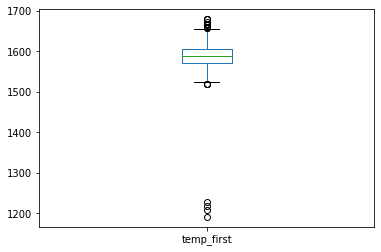

In [101]:
upp_bor, low_bor = clear_outliers(data_full, 'temp_first')

In [102]:
data_full = data_full.query('(@low_bor < temp_first) & (temp_first < @upp_bor)').copy()

Верхняя граница 1617.00, нижняя граница 1569.00
Процент выбросов 7.57%


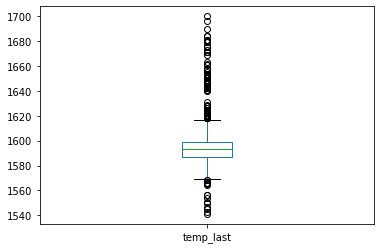

In [103]:
upp_bor, low_bor = clear_outliers(data_full, 'temp_last')

In [104]:
data_full = data_full.query('(@low_bor < temp_last) & (temp_last < @upp_bor)').copy()

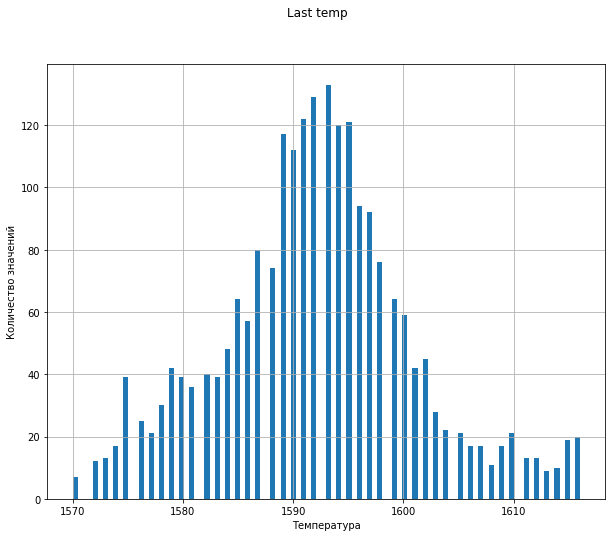

In [105]:
data_full['temp_last'].hist(bins=100, figsize=(10,8));
plt.suptitle('Last temp')
plt.xlabel('Температура')
plt.ylabel('Количество значений')
plt.show()

In [106]:
data_full['temp_last'].nunique()

46

Судя по гистограмме, значения температуры округляются после измерения. Целевая переменная содержит данные о всего лишь 60 уникальных значений температуры. 

Верхняя граница 6.38, нижняя граница -0.46
Процент выбросов 1.69%


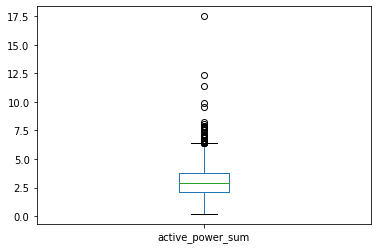

In [107]:
upp_bor, low_bor = clear_outliers(data_full, 'active_power_sum')

In [108]:
data_full = data_full.query('(@low_bor < active_power_sum) & (active_power_sum < @upp_bor)').copy()

Верхняя граница 4.62, нижняя граница -0.27
Процент выбросов 0.91%


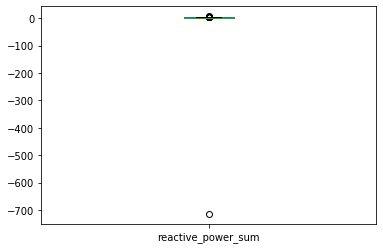

In [109]:
upp_bor, low_bor = clear_outliers(data_full, 'reactive_power_sum')

In [110]:
data_full = data_full.query('(@low_bor < reactive_power_sum) & (reactive_power_sum < @upp_bor)').copy()

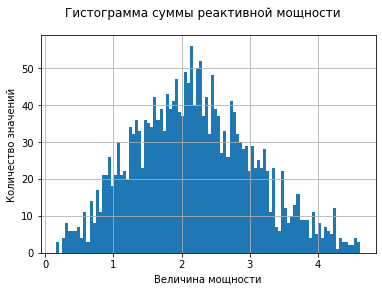

In [111]:
data_full['reactive_power_sum'].hist(bins=100);
plt.suptitle('Гистограмма суммы реактивной мощности')
plt.xlabel('Величина мощности')
plt.ylabel('Количество значений')
plt.show()

Верхняя граница 1522.00, нижняя граница -22.00
Процент выбросов 0.27%


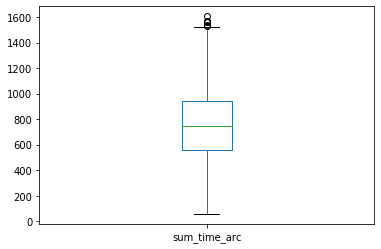

In [112]:
upp_bor, low_bor = clear_outliers(data_full, 'sum_time_arc')

In [113]:
data_full = data_full.query('(@low_bor < sum_time_arc) & (sum_time_arc < @upp_bor)').copy()

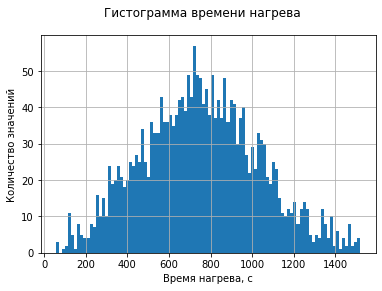

In [114]:
data_full['sum_time_arc'].hist(bins=100);
plt.suptitle('Гистограмма времени нагрева')
plt.xlabel('Время нагрева, с')
plt.ylabel('Количество значений')
plt.show()

Верхняя граница 7.76, нижняя граница -0.48
Процент выбросов 0.05%


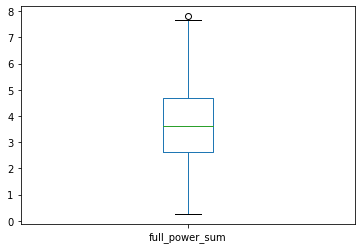

In [115]:
upp_bor, low_bor = clear_outliers(data_full, 'full_power_sum')

In [116]:
data_full = data_full.query('(@low_bor < full_power_sum) & (full_power_sum < @upp_bor)').copy()

Верхняя граница 23.38, нижняя граница -2.68
Процент выбросов 3.90%


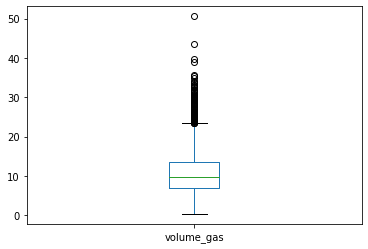

In [117]:
upp_bor, low_bor = clear_outliers(data_full, 'volume_gas')

In [118]:
data_full = data_full.query('(@low_bor < volume_gas) & (volume_gas < @upp_bor)').copy()

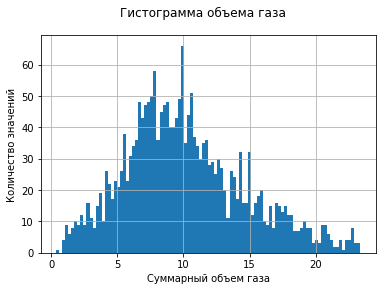

In [119]:
data_full['volume_gas'].hist(bins=100);
plt.suptitle('Гистограмма объема газа')
plt.xlabel('Суммарный объем газа')
plt.ylabel('Количество значений')
plt.show()

Верхняя граница 3551.00, нижняя граница -261.00
Процент выбросов 1.96%


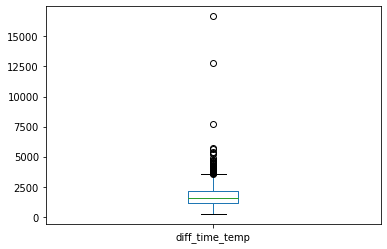

In [120]:
upp_bor, low_bor = clear_outliers(data_full, 'diff_time_temp')

In [121]:
data_full = data_full.query('(@low_bor < diff_time_temp) & (diff_time_temp < @upp_bor)').copy()

Верхняя граница 1242.25, нижняя граница -83.75
Процент выбросов 0.85%


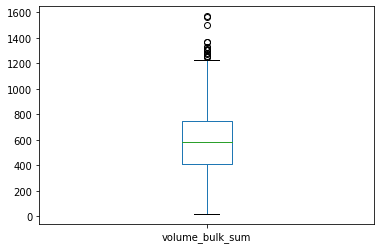

In [122]:
upp_bor, low_bor = clear_outliers(data_full, 'volume_bulk_sum')

In [123]:
data_full = data_full.query('(@low_bor < volume_bulk_sum) & (volume_bulk_sum < @upp_bor)').copy()

Верхняя граница 240.05, нижняя граница -4.62
Процент выбросов 3.54%


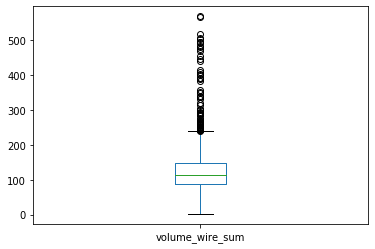

In [124]:
upp_bor, low_bor = clear_outliers(data_full, 'volume_wire_sum')

In [125]:
data_full = data_full.query('(@low_bor < volume_wire_sum) & (volume_wire_sum < @upp_bor)').copy()

In [126]:
data_full.isna().sum()

key                   0
count_arc             0
active_power_sum      0
reactive_power_sum    0
sum_time_arc          0
full_power_sum        0
volume_gas            0
temp_count            0
temp_first            0
temp_last             0
diff_time_temp        0
diff_temp             0
bulk_count            0
volume_bulk_sum       0
Bulk 1                0
Bulk 2                0
Bulk 3                0
Bulk 4                0
Bulk 5                0
Bulk 6                0
Bulk 7                0
Bulk 8                0
Bulk 9                0
Bulk 10               0
Bulk 11               0
Bulk 12               0
Bulk 13               0
Bulk 14               0
Bulk 15               0
wire_count            0
volume_wire_sum       0
Wire 1                0
Wire 2                0
Wire 3                0
Wire 4                0
Wire 5                0
Wire 6                0
Wire 7                0
Wire 8                0
Wire 9                0
dtype: int64

In [127]:
data_full.shape

(1906, 40)

### Вывод

Мы провели очистку данных от выбросов и пропусков. Размер датасета уменьшился до 1906 строк.   
Требуется уточнить на производстве верно ли просиходят измерения температуры и по какому принципу идет округление, получаемых значений.

<a id="glava_5"></a>
## Обучение моделей

Для обучения будем использовать практически все переменные, кроме тех, которые явно указывают на целевую переменную, либо не могут быть известны заранее.

In [128]:
data_full.columns

Index(['key', 'count_arc', 'active_power_sum', 'reactive_power_sum',
       'sum_time_arc', 'full_power_sum', 'volume_gas', 'temp_count',
       'temp_first', 'temp_last', 'diff_time_temp', 'diff_temp', 'bulk_count',
       'volume_bulk_sum', 'Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 'Bulk 5',
       'Bulk 6', 'Bulk 7', 'Bulk 8', 'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
       'Bulk 13', 'Bulk 14', 'Bulk 15', 'wire_count', 'volume_wire_sum',
       'Wire 1', 'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 'Wire 6', 'Wire 7',
       'Wire 8', 'Wire 9'],
      dtype='object')

In [129]:
features = data_full.drop(['key', 'temp_last', 'diff_temp', 'diff_time_temp'], axis=1)
target = data_full['temp_last']

In [130]:
features.shape

(1906, 36)

In [131]:
target.shape

(1906,)

In [132]:
# отделим 25% данных для тестовой выборки
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)

In [133]:
features_train.shape

(1429, 36)

In [134]:
features_train.head()

,count_arc,active_power_sum,reactive_power_sum,sum_time_arc,full_power_sum,volume_gas,temp_count,temp_first,bulk_count,volume_bulk_sum,...,volume_wire_sum,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
1568,5,3.124097,2.473933,760.0,3.989041,11.091015,4.0,1574.0,4.0,704.0,...,223.144467,168.011990,55.132477,0.0,0.0,0.0,0.0,0.0,0.0,0.0
632,5,4.625308,3.474716,1157.0,5.785312,14.371542,4.0,1570.0,3.0,710.0,...,39.967201,39.967201,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34,3,3.040438,1.878162,690.0,3.573990,10.711469,2.0,1585.0,5.0,802.0,...,130.079041,130.079041,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,5,2.304784,2.033236,678.0,3.075474,6.068067,7.0,1604.0,5.0,983.0,...,59.230080,59.230080,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1052,6,3.128599,2.260904,729.0,3.861030,12.323388,8.0,1601.0,3.0,355.0,...,70.106392,70.106392,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Обучение будем проводить для следующих моделей:

*   LinearRegression;
*   RandomForestRegressor;
*   CatBoostRegressor;
*   LGBMRegressor.

Будет использоваться перекрестная проверка и поиск гиперпараметров по сетке.


### LinearRegression

In [135]:
lr = LinearRegression()
scoring = make_scorer(mean_absolute_error, greater_is_better=False)
scores_lr = cross_val_score(lr, features_train, target_train, 
                              scoring='neg_mean_absolute_error', cv=3)
mae_scores_lr = -(scores_lr.mean())
print('Среднее значение MAE при кросс-валидации LinearRegression = {:.2f}'.format(mae_scores_lr))

Среднее значение MAE при кросс-валидации LinearRegression = 5.24


### RandomForestRegressor

In [136]:
param_grid = [
    {'n_estimators': [10, 100],
    'max_features': [2, 4, 6, 8]}    
]
rfr = RandomForestRegressor(random_state=12345)
scoring = make_scorer(mean_absolute_error, greater_is_better=False)
grid_search = GridSearchCV(rfr, param_grid, cv=3,
                          scoring=scoring)
grid_search.fit(features_train, target_train)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(-mean_score, params)
best = grid_search.best_params_
print('Лучшие параметры модели', best)
print('Значение MAE при кросс-валидации RandomForestRegressor = {:.2f}'.format(-mean_score))

5.6860041987403775 {'max_features': 2, 'n_estimators': 10}
5.418503615581992 {'max_features': 2, 'n_estimators': 100}
5.635689293212037 {'max_features': 4, 'n_estimators': 10}
5.344583624912525 {'max_features': 4, 'n_estimators': 100}
5.624842547235828 {'max_features': 6, 'n_estimators': 10}
5.269279216235127 {'max_features': 6, 'n_estimators': 100}
5.37305808257523 {'max_features': 8, 'n_estimators': 10}
5.24808957312806 {'max_features': 8, 'n_estimators': 100}
Лучшие параметры модели {'max_features': 8, 'n_estimators': 100}
Значение MAE при кросс-валидации RandomForestRegressor = 5.25


### CatBoostRegressor

In [137]:
%%time
cbr = CatBoostRegressor(learning_rate=0.01,
                        random_state=12345,
                        verbose=200, 
                       iterations=1000,
                       early_stopping_rounds=1000) 
scores_cbr = cross_val_score(cbr, features_train, target_train, 
                              scoring='neg_mean_absolute_error', cv=3)
mae_scores_cbr = -scores_cbr.mean()
print('Среднее значение MAE при кросс-валидации CatBoostRegressor =', mae_scores_cbr)

0:	learn: 8.5510922	total: 50.1ms	remaining: 50s
200:	learn: 6.5444824	total: 2.87s	remaining: 11.4s
400:	learn: 5.8520412	total: 5.76s	remaining: 8.61s
600:	learn: 5.4133512	total: 8.58s	remaining: 5.7s
800:	learn: 5.0297112	total: 11.5s	remaining: 2.85s
999:	learn: 4.6361530	total: 14.3s	remaining: 0us
0:	learn: 8.4220961	total: 2.85ms	remaining: 2.85s
200:	learn: 6.4964152	total: 2.89s	remaining: 11.5s
400:	learn: 5.7740279	total: 5.73s	remaining: 8.55s
600:	learn: 5.3274643	total: 8.63s	remaining: 5.73s
800:	learn: 4.9265292	total: 11.5s	remaining: 2.86s
999:	learn: 4.5414289	total: 14.3s	remaining: 0us
0:	learn: 8.5022165	total: 2.06ms	remaining: 2.05s
200:	learn: 6.5724149	total: 2.77s	remaining: 11s
400:	learn: 5.9103560	total: 5.76s	remaining: 8.61s
600:	learn: 5.4892503	total: 8.59s	remaining: 5.7s
800:	learn: 5.1076195	total: 11.5s	remaining: 2.85s
999:	learn: 4.7418566	total: 14.4s	remaining: 0us
Среднее значение MAE при кросс-валидации CatBoostRegressor = 4.98273855182086
C

### LGBMRegressor

In [138]:
model_lgbmr = LGBMRegressor(random_state=12345)
param_grid = [{
    'learning_rate':    np.arange(0.05, 0.2, 0.05),
    'max_depth':        np.arange(4, 10, 1, dtype=int)
}]

In [139]:
%%time
grid_search = GridSearchCV(model_lgbmr, param_grid, cv=3,
                          scoring='neg_mean_absolute_error')
grid_search.fit(features_train, target_train)
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(-(mean_score), params)
best = grid_search.best_params_
print('Лучшие параметры модели', best)
print('Значение MAE при кросс-валидации LGBMRegressor = {:.2f}'.format(-mean_score))

5.007740818750181 {'learning_rate': 0.05, 'max_depth': 4}
5.005674763525955 {'learning_rate': 0.05, 'max_depth': 5}
5.00266174281708 {'learning_rate': 0.05, 'max_depth': 6}
4.972418785045732 {'learning_rate': 0.05, 'max_depth': 7}
4.99172353720731 {'learning_rate': 0.05, 'max_depth': 8}
4.981404422606428 {'learning_rate': 0.05, 'max_depth': 9}
5.03040518689628 {'learning_rate': 0.1, 'max_depth': 4}
5.008845509441266 {'learning_rate': 0.1, 'max_depth': 5}
5.018225782116173 {'learning_rate': 0.1, 'max_depth': 6}
4.968888543617488 {'learning_rate': 0.1, 'max_depth': 7}
5.007386413166369 {'learning_rate': 0.1, 'max_depth': 8}
5.0245898484959675 {'learning_rate': 0.1, 'max_depth': 9}
5.087697594576992 {'learning_rate': 0.15000000000000002, 'max_depth': 4}
5.124103105301504 {'learning_rate': 0.15000000000000002, 'max_depth': 5}
5.071444412811073 {'learning_rate': 0.15000000000000002, 'max_depth': 6}
5.089390525445919 {'learning_rate': 0.15000000000000002, 'max_depth': 7}
5.053371027229951 {'

### Обучение на тестовых данных

In [140]:
model_lgbmr = LGBMRegressor(learning_rate=0.01, max_depth=7, random_state=12345)
model_lgbmr.fit(features_train, target_train)
target_predict = model_lgbmr.predict(features_test)
mae = mean_absolute_error(target_test, target_predict)
print('MAE на тестовой выборке {:.2f}'.format(mae))

MAE на тестовой выборке 5.22


Все модели получили отличный результат метрики MAE.  
Наиболее точной оказалась модель градиентного бустинга LGBMRegressor. Величина метрики MAE 5.19.

<a id="glava_6"></a>
## Анализ модели

Проведем анализ важности признаков **feature_importance** и заново проведем обучение модели с уменьшенным количеством признаков.

In [141]:
feature_lgbmr = pd.DataFrame(sorted(zip(model_lgbmr.feature_importances_,features_train.columns)), columns=['Value','Feature'])
feature_lgbmr = feature_lgbmr.sort_values(by="Value", ascending=False).copy()

In [142]:
feature_lgbmr

,Value,Feature
35,827,temp_first
34,528,active_power_sum
33,230,volume_gas
32,183,Bulk 14
31,146,Bulk 6
30,136,Wire 2
29,134,sum_time_arc
28,109,Wire 1
27,89,Bulk 15
26,77,full_power_sum


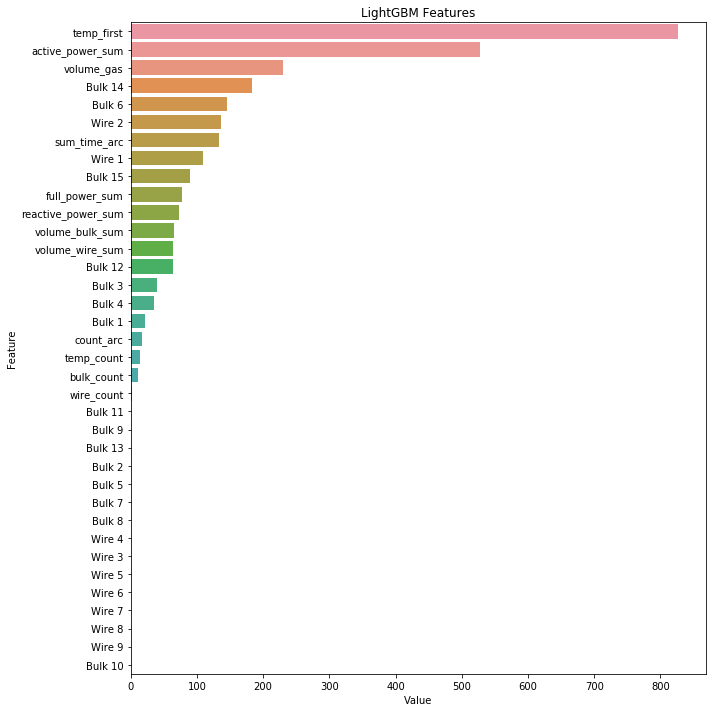

In [143]:
#@title
plt.figure(figsize=(10, 10))
sns.barplot(x="Value", y="Feature", data=feature_lgbmr)
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

Выделим наименее важные признаки

In [144]:
bad_features = list(feature_lgbmr['Feature'][feature_lgbmr['Value'] < 10])
bad_features

['wire_count',
 'Bulk 11',
 'Bulk 9',
 'Bulk 13',
 'Bulk 2',
 'Bulk 5',
 'Bulk 7',
 'Bulk 8',
 'Wire 4',
 'Wire 3',
 'Wire 5',
 'Wire 6',
 'Wire 7',
 'Wire 8',
 'Wire 9',
 'Bulk 10']

Проверим данные на мультиколлинеарность. 

Для этого создадим функцию **vif_scores** для вычисления VIF (variation inflation factor) – коэффициент вздутия дисперсии.

In [145]:
def vif_scores(df):
    VIF_Scores = pd.DataFrame()
    VIF_Scores['independent_features'] = df.columns
    VIF_Scores["VIF_Scores"] = [variance_inflation_factor(df.values,i).round(4) for i in range(df.shape[1])]
    return VIF_Scores

In [146]:
vif_scores_df = vif_scores(features).copy();

/opt/conda/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
/opt/conda/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1638: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


In [147]:
vif_scores_main = vif_scores_df[(vif_scores_df['VIF_Scores'] > 1) & (vif_scores_df['VIF_Scores'] != np.inf)].sort_values(by='VIF_Scores', ascending=False)
vif_scores_main 

,independent_features,VIF_Scores
4,full_power_sum,75410.5626
1,active_power_sum,28896.9723
2,reactive_power_sum,11474.5020
3,sum_time_arc,234.5950
7,temp_first,41.2648
0,count_arc,33.5268
8,bulk_count,31.1890
25,wire_count,19.7908
6,temp_count,12.6776
5,volume_gas,7.6198


При коэффициенте VIF > 10 принято считать, что в данных присутствует мультиколлинеарность.  

Данную проблему, в нашем случае, можно решить нескольким путями:  
- убрать некоторые переменные;
- оставить искуственно созданные переменные, которые описывают исходные.

In [148]:
vif_scores_main.query('VIF_Scores > 10')['independent_features'].tolist()

['full_power_sum',
 'active_power_sum',
 'reactive_power_sum',
 'sum_time_arc',
 'temp_first',
 'count_arc',
 'bulk_count',
 'wire_count',
 'temp_count']

Создадим новые обучающие и тестовые данные. Для этого исключим из обучающих данных наименее важные признаки и избавимся от мультиколлениарных переменных.

In [149]:
features_new = data_full.drop(['key', 'temp_last', 'diff_temp', 'diff_time_temp', 
 'active_power_sum',
 'reactive_power_sum',
 'sum_time_arc',
 'temp_first',
 'count_arc',
 'bulk_count',
 'wire_count',
 'temp_count',
 'wire_count',
 'Bulk 11',
 'Bulk 9',
 'Bulk 13',
 'Bulk 2',
 'Bulk 5',
 'Bulk 7',
 'Bulk 8',
 'Wire 4',
 'Wire 3',
 'Wire 5',
 'Wire 6',
 'Wire 7',
 'Wire 8',
 'Wire 9',
 'Bulk 10'], axis=1)
target_new = data_full['temp_last']

In [150]:
features_new.head()

,full_power_sum,volume_gas,volume_bulk_sum,Bulk 1,Bulk 3,Bulk 4,Bulk 6,Bulk 12,Bulk 14,Bulk 15,volume_wire_sum,Wire 1,Wire 2
1,3.649216,12.555561,582.0,0.0,0.0,73.0,0.0,206.0,149.0,154.0,96.052315,96.052315,0.00000
4,4.035758,5.413692,584.0,0.0,0.0,78.0,0.0,203.0,151.0,152.0,98.352796,89.238236,9.11456
5,4.786837,11.273392,676.0,0.0,0.0,117.0,0.0,204.0,201.0,154.0,108.224477,99.109917,9.11456
6,2.987777,9.836267,627.0,0.0,0.0,117.0,0.0,204.0,152.0,154.0,98.061600,98.061600,0.00000
7,4.627389,15.171553,914.0,0.0,0.0,99.0,0.0,410.0,252.0,153.0,155.282394,155.282394,0.00000


In [151]:
# отделим 25% данных для тестовой выборки
features_train, features_test, target_train, target_test = train_test_split(features_new, target_new, test_size=0.25, random_state=12345)

In [152]:
%%time
model_lgbmr = LGBMRegressor(learning_rate=0.05, max_depth=5, random_state=12345)
model_lgbmr.fit(features_train, target_train)
target_predict = model_lgbmr.predict(features_test)
mae = mean_absolute_error(target_test, target_predict)
print('MAE на тестовой выборке {:.2f}'.format(mae))

MAE на тестовой выборке 5.57
CPU times: user 793 ms, sys: 18.2 ms, total: 811 ms
Wall time: 800 ms


### Вывод

Выделены наиболее выжные признаки. Проведено повтороне обучение модели.  

Условие задачи выполнено, даже с учетом очистки в features большого количества переменных. 

Значение метрики для модели градиентного бустинга *LGBMRegressor* **MAE = 5.57**.

<a id="conclusion"></a>
# Общий вывод

Производственный процесс представляет из себя цикл этапов, включающих опускание электродов в ковш(нагрев), добавление сыпучих материалов и проволки, продувка газов, замеры температуры.  

Данные о последнем измерении температуры являются **целевой переменной**.     

Изменения зафиксированной температуры находятся в диапазоне от 1191 до 1705 градусов.  

Таблицы, описывающие разные этапы и циклы производства собраны в единый датасет.  

Проведена очистка данных от выбросов и пропусков. Размер датасета уменьшился до 1906 строк. Потери составляют ~40% от первоначальных данных.

Обучены модели:  
* LinearRegression;
* RandomForestRegressor;
* CatBoostRegressor;
* LGBMRegressor.

Проведен анализ модели LGBMRegressor и ее **feature_importance**. Выявлены в данных переменные, имеющие признаки мультиколлениарности. 

Для очищенных данных от наименее важных признаков, и исключающих признаки мультиколлениарности, значение метрики модели **LGBMRegressor**  
**MAE = 5.57**.

Рекомендации:
* увеличить количество наблюдений;
* требуется уточнить на производстве, с чем связанны окургление значений температуры;
* провести аудит и контроль качества получаемых данных;
* предоставить технологическую карту процесса изготовления продукции, для уточнения пределов значений переменных.